In [1]:
#https://stackoverflow.com/questions/11869910/pandas-filter-rows-of-dataframe-with-operator-chaining
import pandas as pd
import numpy as np
import datetime
from dateutil import parser
from datetime import datetime, timedelta 

In [2]:

category = { 
    'ShipNt' :  "Receipt",
    'SchLne' :  "Receipt",    
    'Stock'  :  "Receipt",
    'PlOrd.'  :  "Receipt",
    'CStock' : "Reqmt",
    'Ordres' : "Reqmt",    
    'Order'  :  "Reqmt",
    'Deliv.' : "Reqmt",
    'PrdOrd' : "", #normally assigned together with cstock. no need to count
    'OrdRes' : "Reqmt",
    'TrRes.' : "Reqmt",
    'DepReq' : "Reqmt",
    'RelOrd' : "Reqmt",
    'Fr.del' : "Reqmt",
    #'SafeSt' : "Reqmt", #For GPC Production
    'SafeSt' : "", #For 360 F-KR, which would consume SafeST as well.
    'StLcSt' : "",
    'PurRqs' : "",
    '----->' : "",
    'IndReq' : ""
}
header=["Partnr","SO_Date","SO_MRP", "SO_NR", "SO_POS","SO_QTY", "PO_DATE","PO_MRP","PO_NR", "PO_POS","PO_QTY"]
metaheader=['partnr', 'description', 'MRP', 'TYPE', 'PLANT', 'LT']
total=[]   

In [3]:
#filter using chain method 
def mask(df, key, value):
    return df[df[key] == value]
pd.DataFrame.mask = mask

In [4]:
def fileRead(filename) :    
    count=0    
    
    with open(filename,"r", encoding="ISO-8859-1") as file:
        document= file.readlines() 
        #print("Reading the file as raw format" , filename)
    return document #read whole content in "document"

In [5]:
def orderRead(filename) : 
    document=fileRead(filename)
    partnr=document[5].split("             ")[1].strip()
    orderList=[]
    #print(document[20])
    try : 
        clientLocation=document[20].split("|").index("Customer  ")
    except :
        clientLocation=-1

    for line in document[22:-3] : 
        splitLine=line.split("|")
        type=splitLine[3].strip()    
        
        if (category[type]=='Reqmt') : 
            try : 
                qty=int(float(splitLine[7].replace("-","")))
            except :
                qty=0
                
            order= (partnr,splitLine[2].strip(), splitLine[4][:10].strip(), qty, splitLine[clientLocation])
            #print(order)
            orderList.append(order)

    return pd.DataFrame(orderList, columns=["partnr", "date", "so","qty","client"] )

In [6]:
def fehaParser(ReqmtQueue, ReceiptQueue) :
    
    MappedResult=[]
    flag=0
    Receipt=[]
    Reqmt=[]
    
    
    try :       
        Receipt = ReceiptQueue.pop(0)        
        Reqmt = ReqmtQueue.pop(0)  

        while True :                 
            #print (Receipt[5], Reqmt[5])
            if Receipt[5] + Reqmt[5] == 0 :                    
                flag=0
                MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], Reqmt[5],  Receipt[1], Receipt[2], Receipt[3], Receipt[4], Receipt[5]])    
                
                if len(ReceiptQueue) +  len(ReqmtQueue) <=0 : return MappedResult                        

                Receipt=[]; Receipt = ReceiptQueue.pop(0)
                Reqmt=[]; Reqmt = ReqmtQueue.pop(0)  

            if Receipt[5] + Reqmt[5] > 0 :                           
                flag=1
                MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], Reqmt[5],  Receipt[1], Receipt[2], Receipt[3], Receipt[4], -Reqmt[5]])    
                Receipt[5] +=Reqmt[5]            
                Reqmt = ReqmtQueue.pop(0)  


            if Receipt[5] + Reqmt[5] < 0 :                                
                flag=-1
                MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], -Receipt[5],  Receipt[1], Receipt[2], Receipt[3], Receipt[4], Receipt[5]])
                Reqmt[5] +=Receipt[5]
                Receipt = ReceiptQueue.pop(0)

        #if no elment for popping.  
    except Exception as e:   

        if flag == -1:
            MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], Reqmt[5],'','' ,'' ,'' ,'' ]) 
        elif flag == 1:
            MappedResult.append([Receipt[0], '','','','','',  Receipt[1], Receipt[2], Receipt[3], Receipt[4], Receipt[5]])          

        elif flag == 0:                


            if len(Reqmt) == 0 and len(Receipt)==0 :                     
                print("both empty")
            elif len(Reqmt) == 0 and len(Receipt)!=0: 
                ##print("Reqmt empty")
                MappedResult.append([Receipt[0], '','','','','',  Receipt[1], Receipt[2], Receipt[3], Receipt[4], Receipt[5]])          
            elif len(Reqmt) !=0 and len(Receipt) ==0 :                
                ##print("Receipt empty")
                MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], Reqmt[5],'','' ,'' ,'' ,'' ]) 


        for Reqmt in ReqmtQueue :
            MappedResult.append([Reqmt[0], Reqmt[1], Reqmt[2], Reqmt[3], Reqmt[4], Reqmt[5],'','' ,'' ,'' ,'' ]) 

        for Receipt in ReceiptQueue :
            MappedResult.append([Receipt[0], '','','','','',  Receipt[1], Receipt[2], Receipt[3], Receipt[4], Receipt[5]])          

        return MappedResult
            

In [7]:
def parsingDoc(document) :
    #line 6 for material # and material description
    
    
    partnr=document[5].split("             ")[1].strip()
    description=document[5].split("             ")[2].strip()
    plnt=document[6].split()[2].strip()    
    #print("plnt number", plnt)
    if plnt!='0360' : category['SafeSt'] = "Reqmt" #If plnt is not 0360 (F-KR), safety stock should be reqmt 
    
    
    #line9 MRP type / Matl Type
    MRP=document[8].split()[3];
    MatlType=document[8].split()[6];

    #line11 Purchasing Group
    PurGrp=document[10].split()[2]; 

    #line12
    leadtime=document[11].split()[4];

    meta=[partnr,description, MRP, MatlType, PurGrp, leadtime]
    header=["Partnr", "Date","Type","DocNum","Pos","Change","Avail"]
    data=[]

    for line in document[22:-3] :
        cursor=line.split("|")
                
        #doc/pos number extracted
        try :            
            docNum=cursor[4].strip().split("/")[0]
            pos=cursor[4].strip().split("/")[1]
        
        except Exception as e:
            docNum=cursor[4].strip()
            pos=0
        
        #qty extracted 
        try  :
            if int(cursor[7][-1] == "-") :                      
                 qty=(-int(float((cursor[7][0:-1].strip().replace(",","")))))
            
            else:                
                qty=((int(float(cursor[7].strip().replace(",","")))))
        
        except Exception as e:
            qty=0
            
        #avail number extracted 
        try : 
            if int(cursor[8][-1] == "-") :      
                avail=(-int(float((cursor[8][0:-1].strip().replace(",","")))))
            else:
                avail=((int(float(cursor[8].strip().replace(",","")))))                
                
        except Exception as e:
            avail=0            
        datum = [partnr, cursor[2].strip(), cursor[3].strip(), docNum, pos, qty, avail]
        data.append(datum)
    
    md04={"meta":meta, "header": header, "data":data}
    return md04

In [8]:
#Direct Procurmeent Extractor
def directProcurementParser(mdlist) : 
    flag=False
    
    DIRECTPROCUREMENT=[] #final result
    idxs=[] #index numbers for reomving
    
    
    for idx, line in enumerate(mdlist): 
        type=line[2]                
        #signal
        if (type=='----->') :
            idxs.append(idx)
            flag=True
            continue    
        #Receipt
        if(flag==True and category[type]=='Reqmt') :       
            reqmt=line 
            idxs.append(idx)

        if(flag==True and category[type]=='Receipt') :       
            receipt=line
            flag=False 
            pair=reqmt[0:5] + receipt [5:6] + receipt [1:6]
            idxs.append(idx)
            #print(pair)        
            DIRECTPROCUREMENT.append(pair)
    return DIRECTPROCUREMENT, idxs

In [9]:
#KMAT PARSER

def kmatParser(mdlist) :
    flag=False
    KMAT=[] #final result
    idxs=[] #index numbers for reomving
    
    for idx, line in enumerate(mdlist):         

        type=line[2]            

        #Requirement    
        if (flag==False) and (type=='CStock') :                                 
            flag=True
            reqmt=line
            idxs.append(idx)
            continue    
        #Receipt
        if(flag==True) :       
            receipt=line        
            if type!='CStock':
                flag=False 
                pair=reqmt[0:5] + [-receipt [5]] + receipt [1:6]
                idxs.append(idx)

            if type=='CStock':             
                pair=reqmt[0:5] + [-reqmt[6]] + ["","" ,"" ,"" ,reqmt[6] ]
                reqmt = line
                idxs.append(idx)
            #print(pair)        
            KMAT.append(pair)  
    return KMAT, idxs

In [10]:
#To save excel file 
def excelConversion(MD04,ORDER,META) : 
    writer=pd.ExcelWriter(str(datetime.datetime.now().date()) + '_unit_output.xlsx')
    MD04.to_excel(writer,'Sheet1')
    ORDER.to_excel(writer,'Sheet2')
    META.to_excel(writer,'Sheet3')
    writer.save()

In [11]:

#read file as list type
def unitParser(filename) : 
    textFile=fileRead(filename)

    #parsing doc 
        # md04['data']  = line infomration
        # md04['header']. # md04['meta']= Meta information 

    md04=parsingDoc(textFile) 
    PD=pd.DataFrame(md04["data"], columns=md04["header"])   
    df=PD.iloc[:,0:7]   
    mdList=md04['data']
        
    #DIRECT PROCUREMENT, KMAT
    DIRECTPROCUREMENT, idxsDirectProcurement =directProcurementParser(mdList)
    KMAT, idxsKMAT =kmatParser(mdList)
    idxs= idxsDirectProcurement+idxsKMAT
    
    #FEHA
    remaining = [v for i, v in enumerate (mdList) if i not in idxs]        
        
    ReceiptQueue=[item for item in remaining if category[item[2]]=='Receipt']
    ReceiptQueue[0][5]= ReceiptQueue[0][6]        #STOCK Treatment

    ReqmtQueue=[item for item in remaining if category[item[2]]=='Reqmt']
   

    

    QUEUE= pd.DataFrame(ReceiptQueue+ ReqmtQueue, columns=md04['header'])
    
    #Stock pretreatment
    #QUEUE['Change'][0]= QUEUE['Avail'][0]
    
    
    #Date pretreatment
    #yesterday = datetime.now() - timedelta(days=1)    
    QUEUE['Date'] = QUEUE['Date'].apply(lambda x:parser.parse(x))
    QUEUE.loc[QUEUE.Date < datetime.now(), 'Date']=  datetime.now()
    
    
    #Sorted by date in ascending order
    QUEUE=QUEUE.sort_values(by=['Date'])
    QUEUE['Avail']=QUEUE['Change'].cumsum()
    
    
    
    
    
    
    FEHA=fehaParser(ReqmtQueue, ReceiptQueue)
    
    #RESULT TO BE IN DATAFRAME
    MD04=pd.DataFrame(pd.DataFrame((FEHA + KMAT + DIRECTPROCUREMENT), columns=header))


    #ORDER LIST
    ORDER=orderRead(filename)

    #META
    META=pd.DataFrame([md04['meta']], columns=metaheader)
    
    
    
    
    
    
    
    return MD04,ORDER,META,QUEUE

# UNIT TEST

In [54]:
result=unitParser("352336")

In [55]:
excelConversion(result[0],result[1],result[2])

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

## ACTUAL RUNNING (for MD04list.txt)

In [12]:
from os import listdir
from os.path import isfile, join
#mypath="C:\\dev\\MD04\\180801"
mypath="C:\\dev\\MD04\\CLEARING\\180809"
#filelist = [mypath + "\\" + f for f in listdir(mypath)]
filelist = [mypath + "\\" + f for f in listdir(mypath) if f.find("xls")<0]

In [13]:
total=[]
#filelist=[]
totalOrder=[]
totalMeta=[]
totalQueue=[]

#f=open("MD04list.txt","r", encoding="UTF-8")
#list=f.readlines()

for i in filelist :    
    RESULT=unitParser(i.replace("\n",""))    
    total.append(pd.DataFrame(RESULT[0], columns=header))
    totalOrder.append(RESULT[1])
    totalMeta.append(RESULT[2])
    totalQueue.append([RESULT[3]])

## EXCEL FILE 

In [14]:
final=pd.DataFrame()
orderfinal=pd.DataFrame()
metafinal=pd.DataFrame()
queuefinal=pd.DataFrame()

for i in total : 
        final=final.append(i)

for i in totalOrder : 
        orderfinal=orderfinal.append(i)
        
        
for i in totalMeta : 
        metafinal=metafinal.append(i)
                
for i in totalQueue : 
        queuefinal=queuefinal.append(i)

In [15]:
#To save excel file 
writer=pd.ExcelWriter(mypath + "\\" + str(datetime.now().date()) + '.xlsx')
final.to_excel(writer,'Sheet1')
orderfinal.to_excel(writer, 'Sheet2')
metafinal.to_excel(writer, 'Sheet3')
queuefinal.to_excel(writer, 'Sheet4')
writer.save()

In [16]:
partnrs=queuefinal[queuefinal['Avail']<0].Partnr.unique()
#partnrs=queuefinal[queuefinal['Change']<0].Partnr.unique()

listofpartnr=['151873', '151865', '151870', '151863', '151874']
partnrs=queuefinal[queuefinal['Partnr'].isin(listofpartnr)].Partnr.unique()



In [17]:
for partnr in partnrs :     
    part=mask(queuefinal,"Partnr", partnr)
    part.plot(x='Date',y='Avail', title=partnr, figsize =(10,5))

C:\dev\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


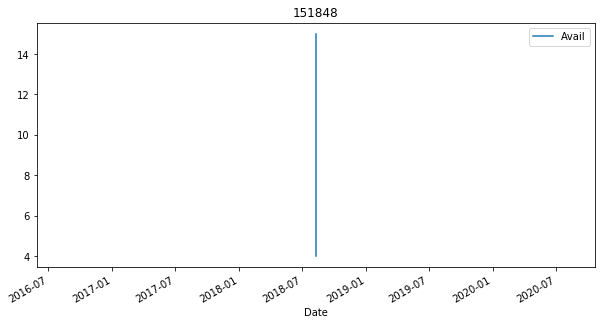

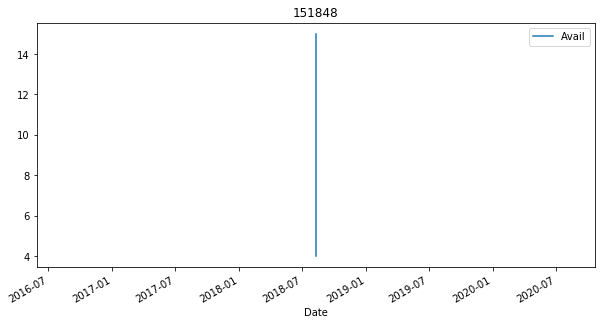

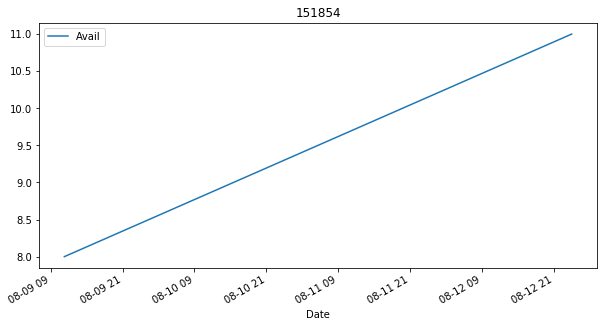

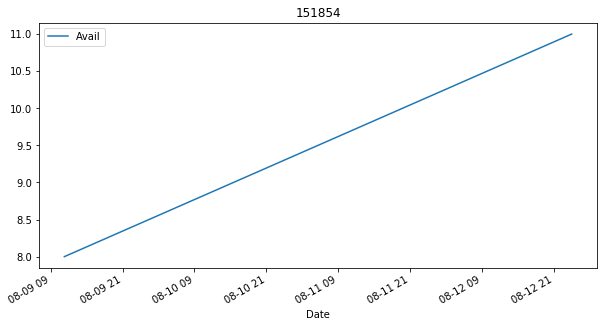

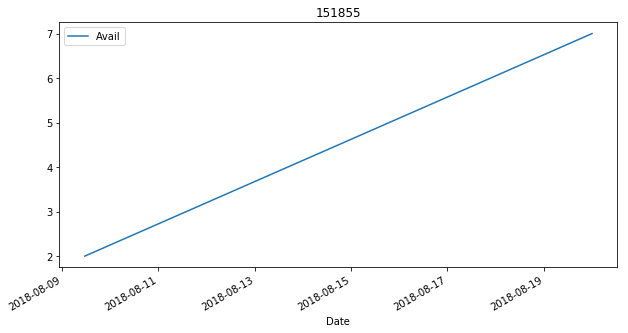

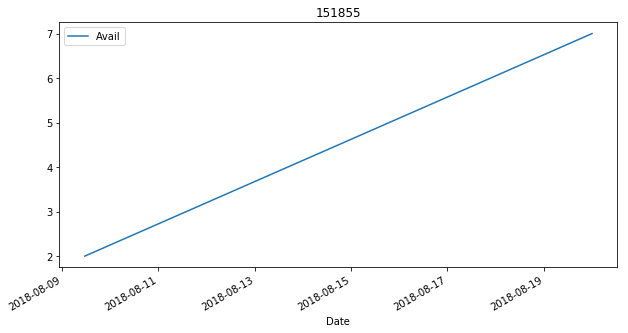

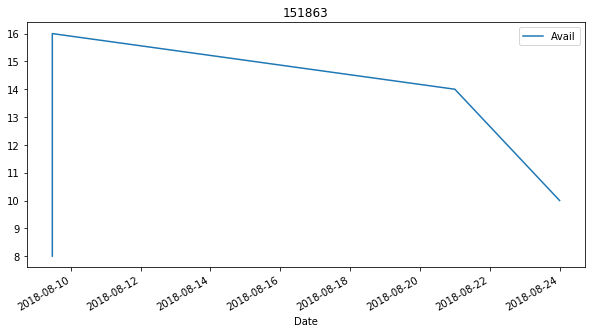

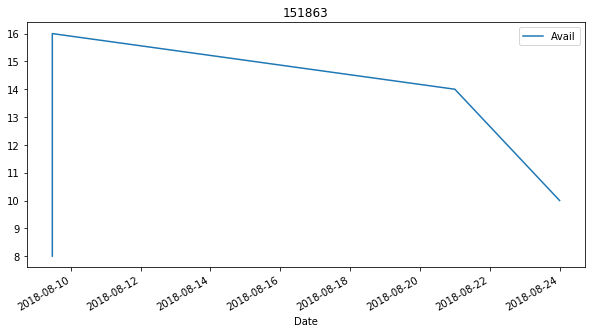

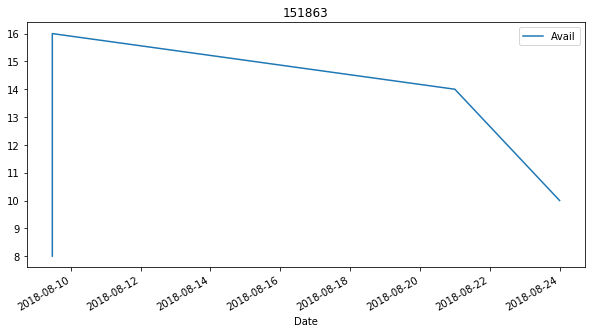

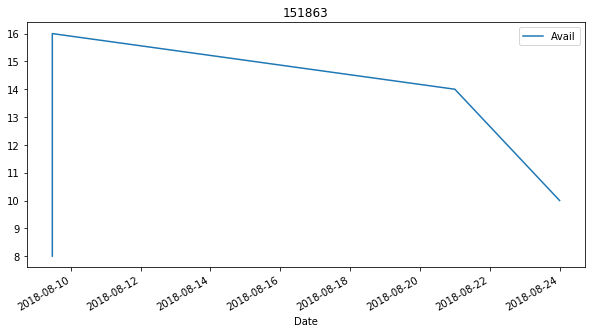

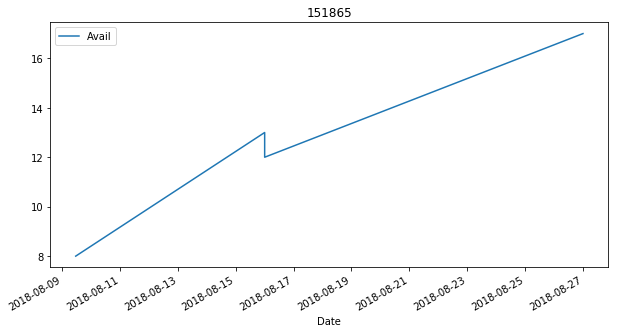

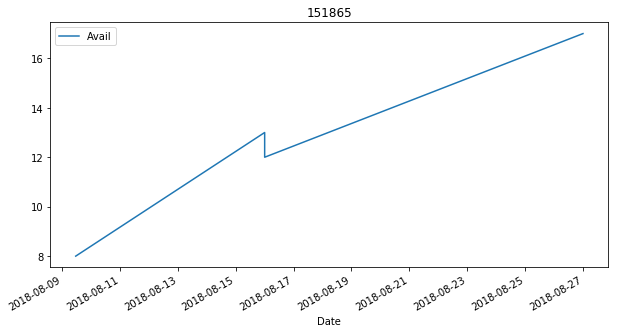

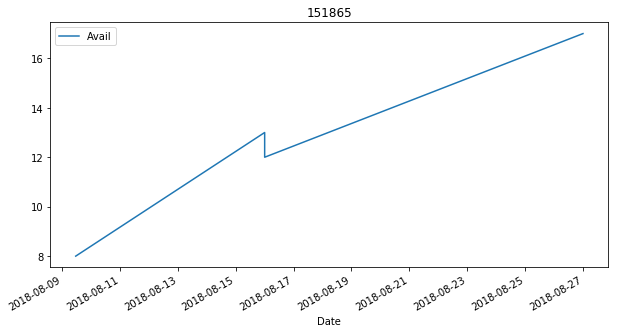

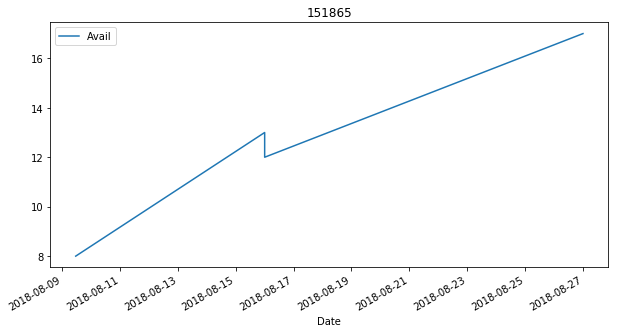

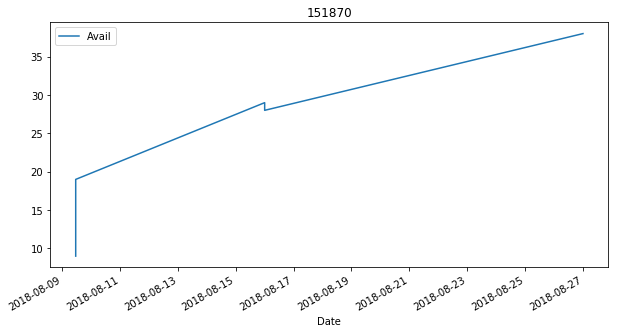

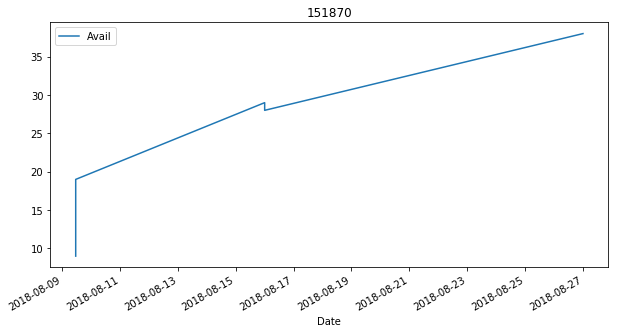

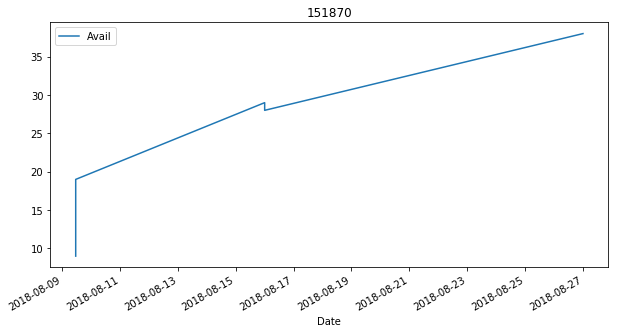

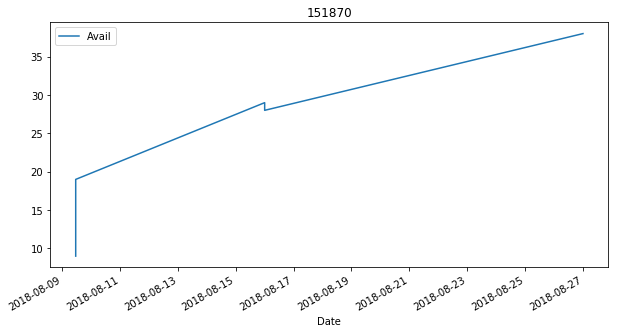

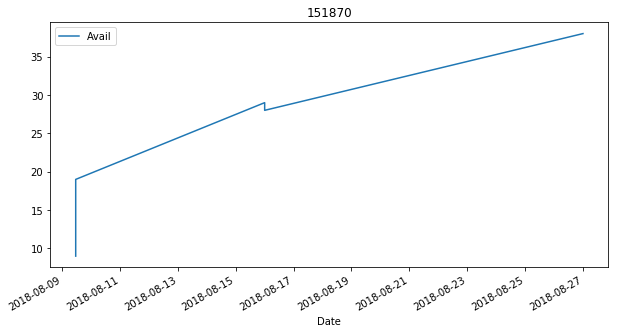

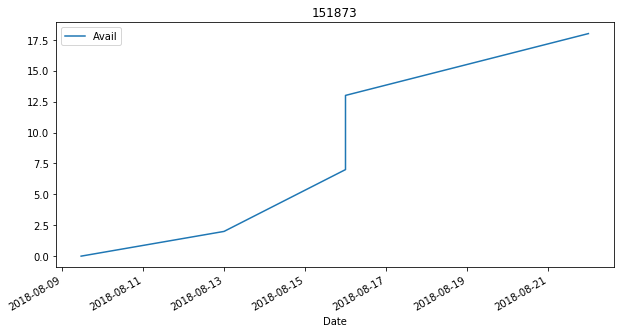

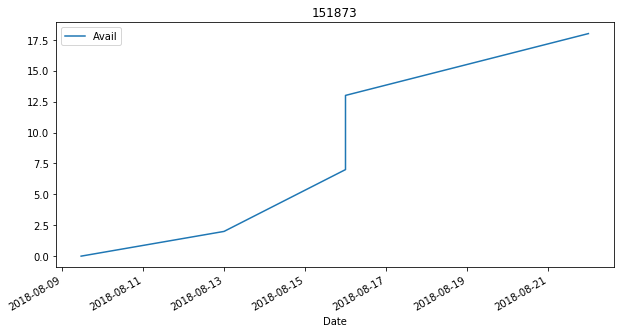

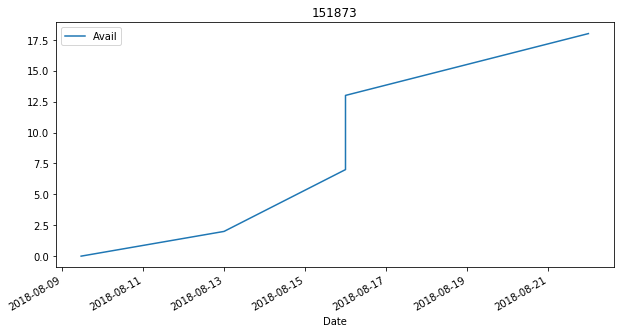

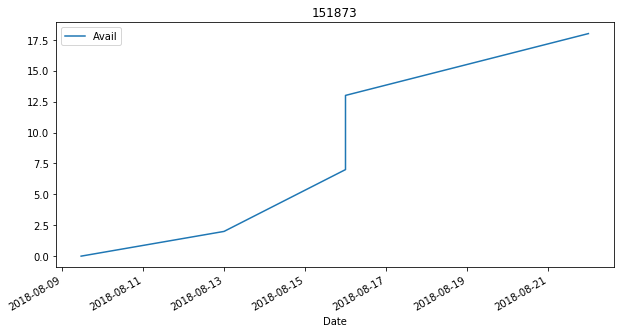

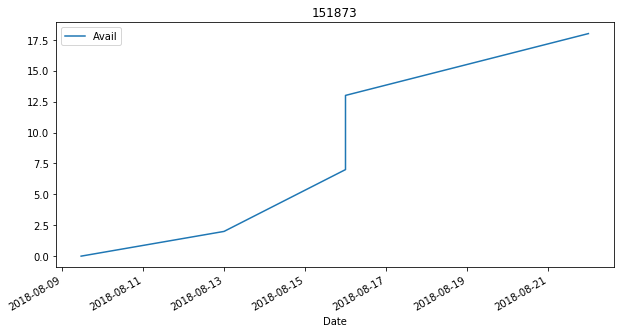

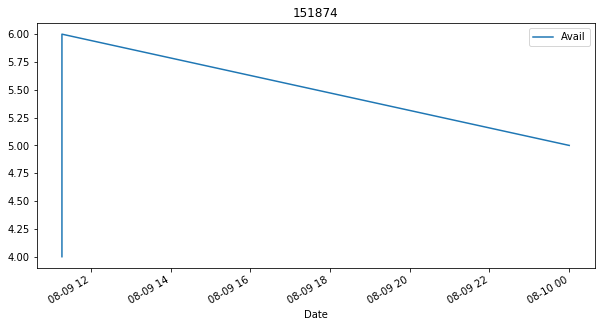

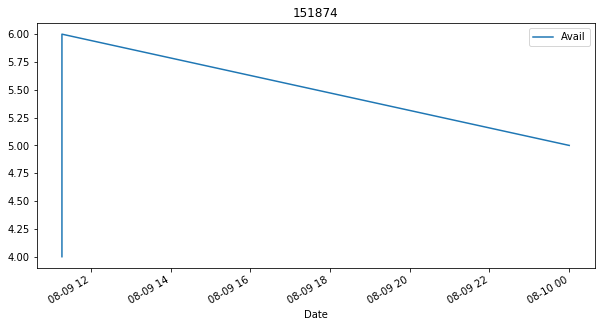

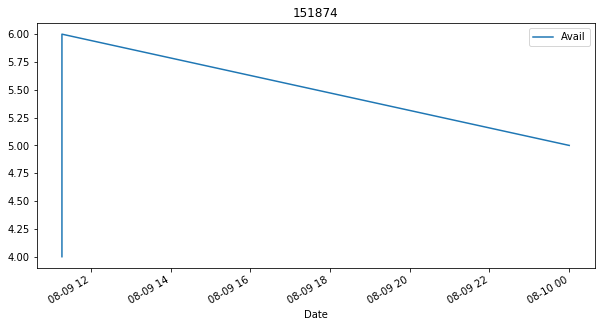

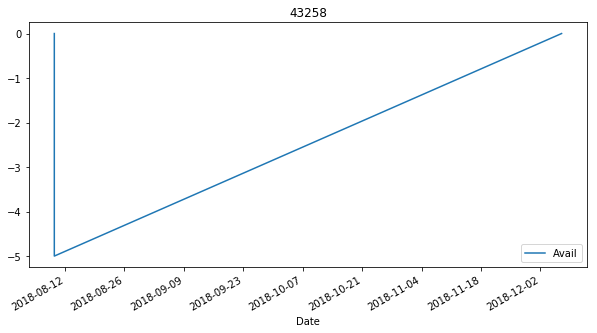

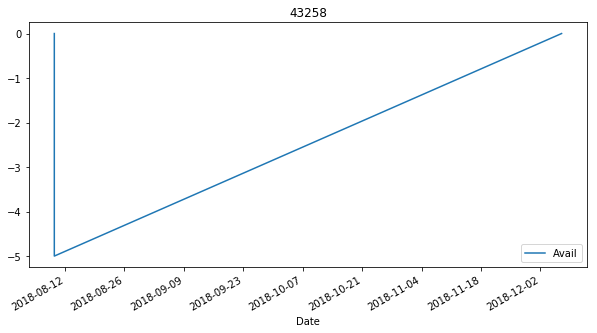

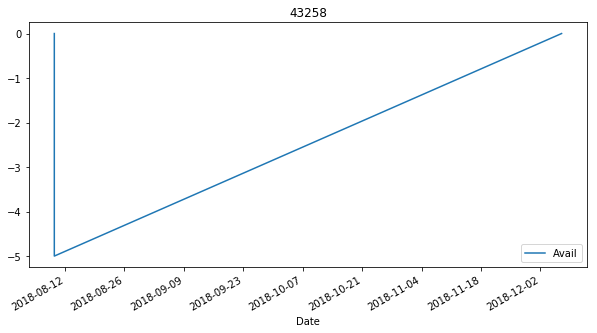

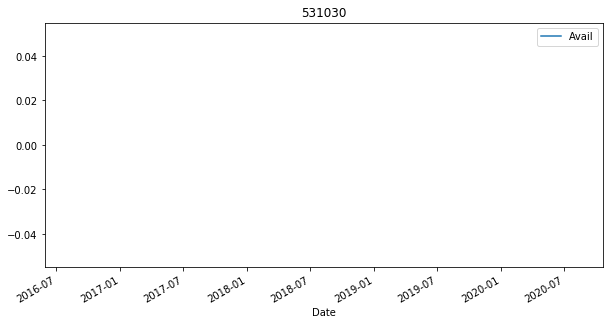

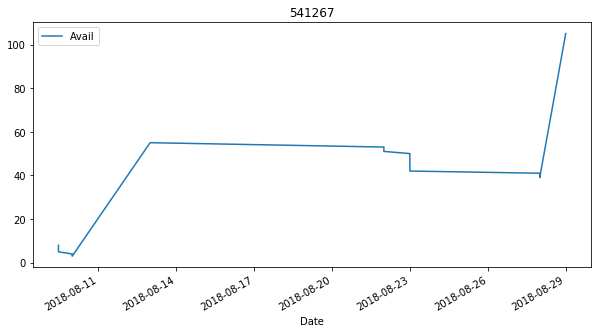

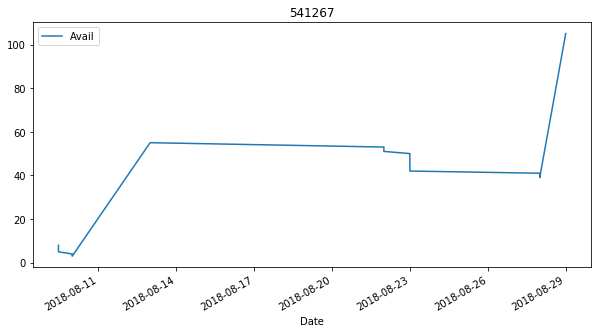

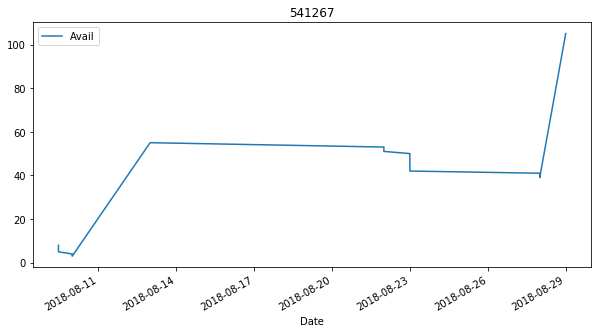

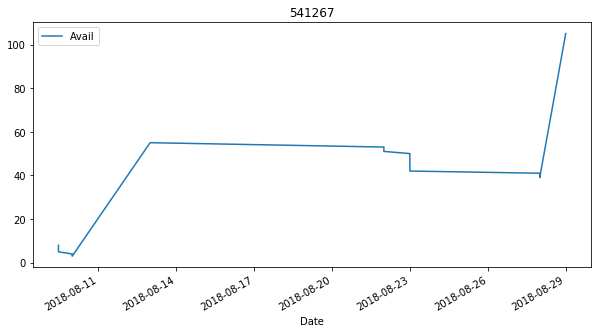

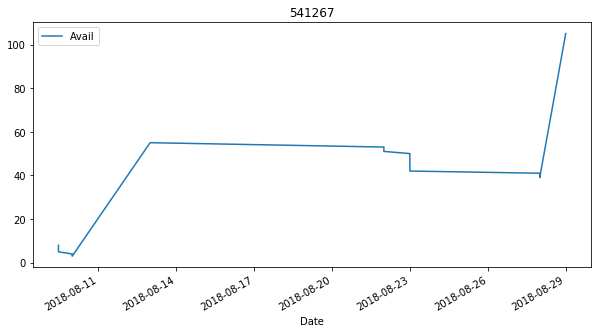

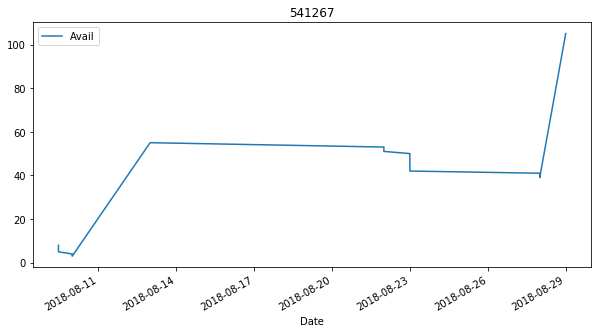

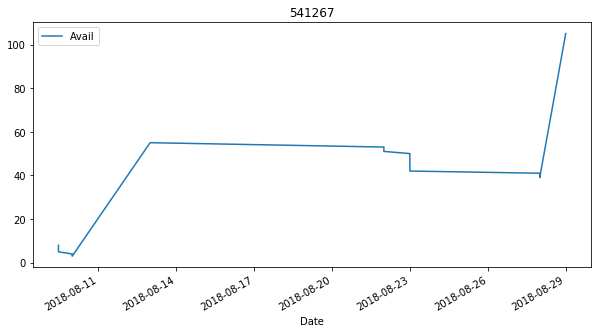

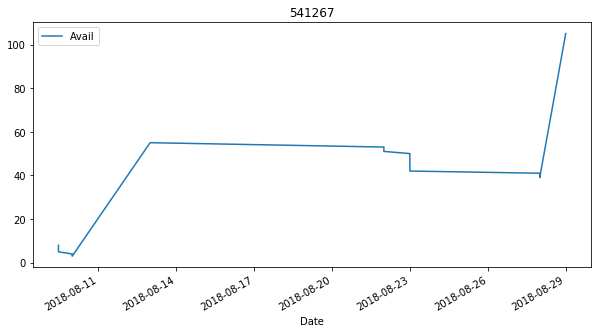

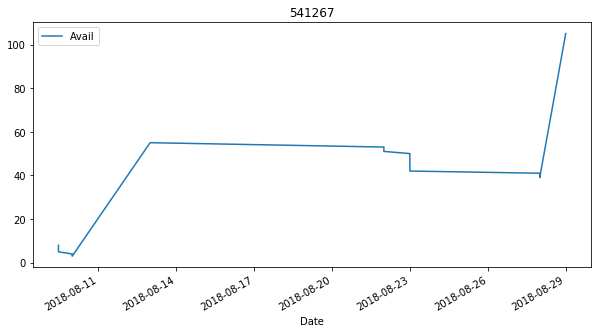

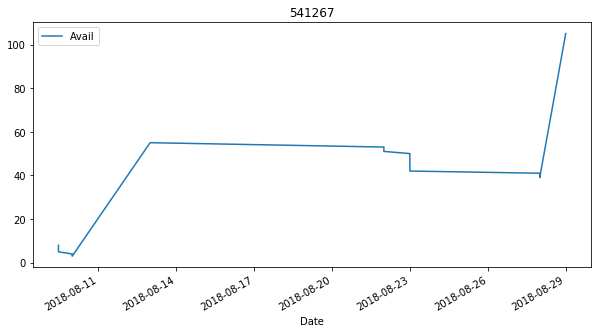

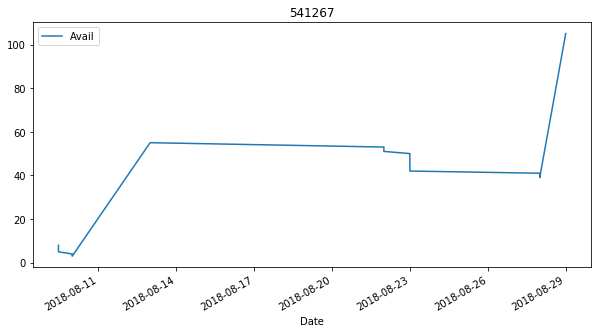

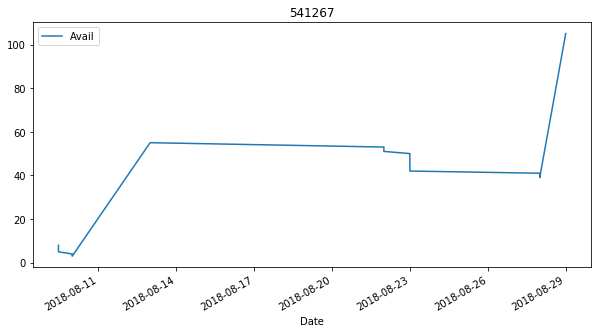

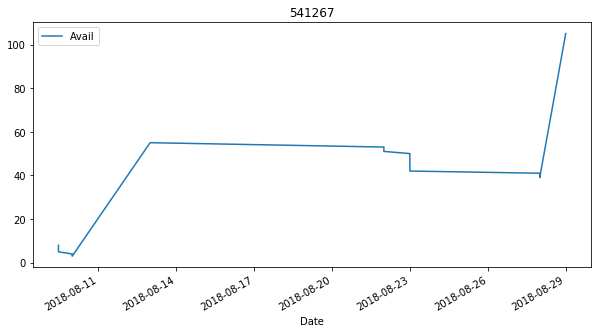

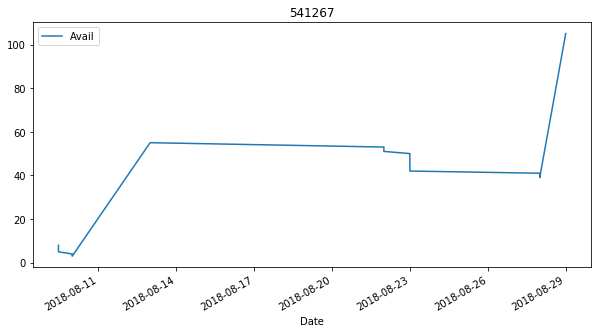

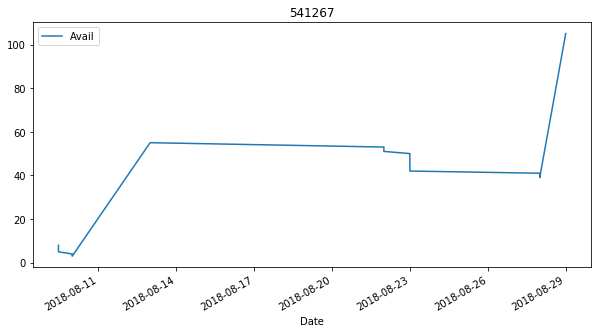

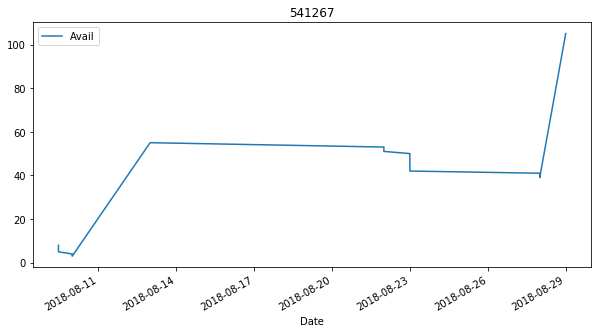

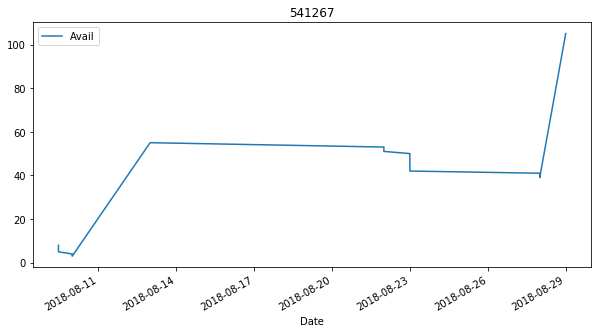

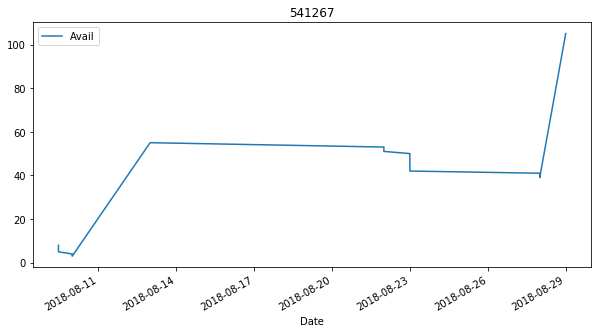

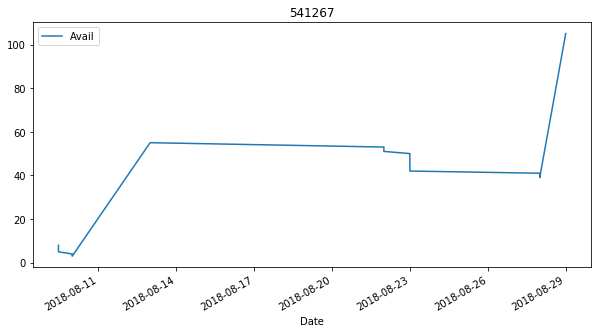

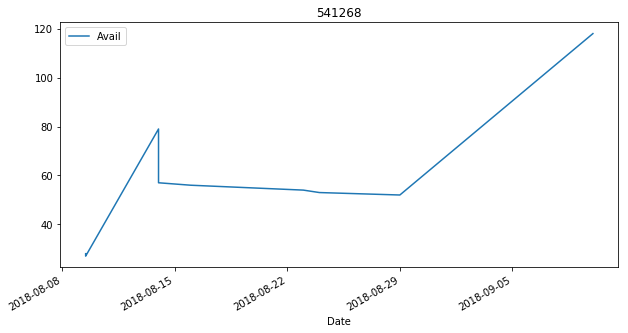

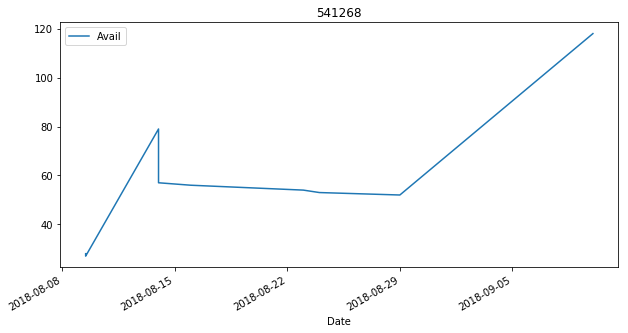

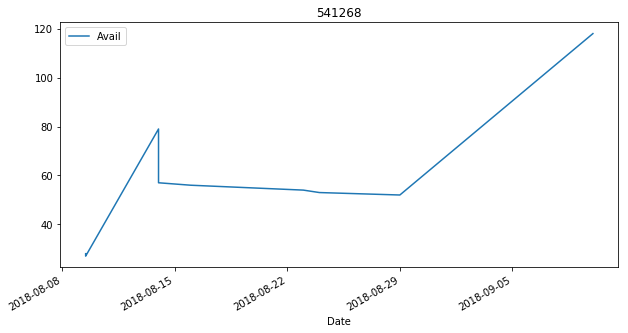

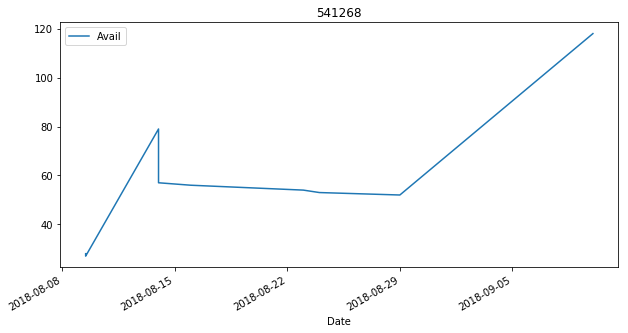

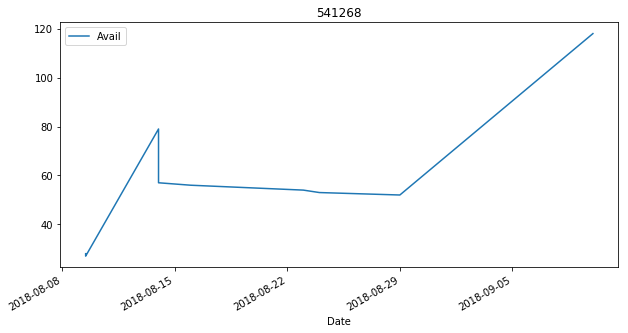

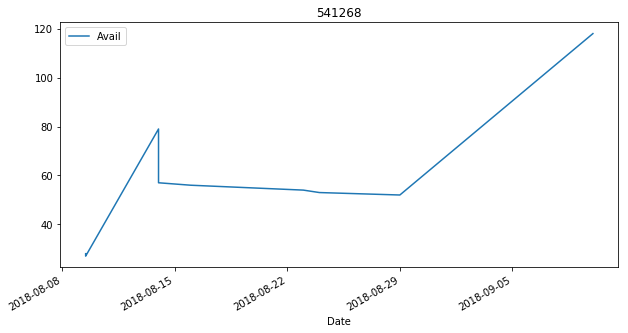

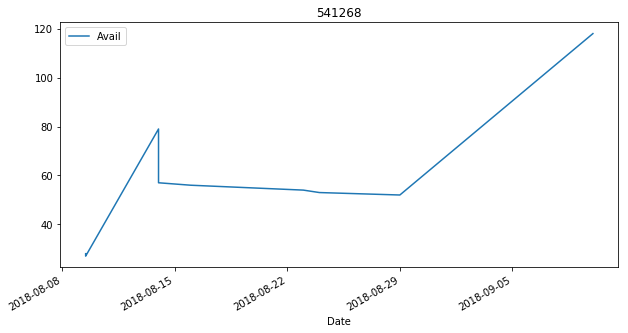

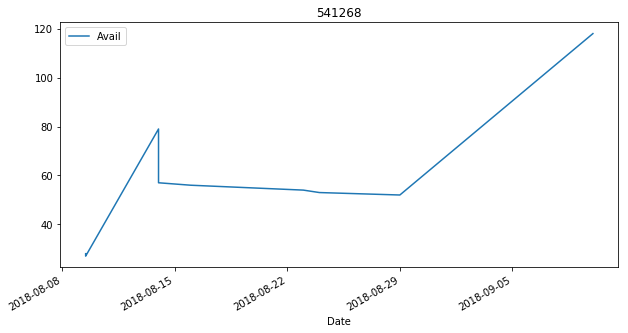

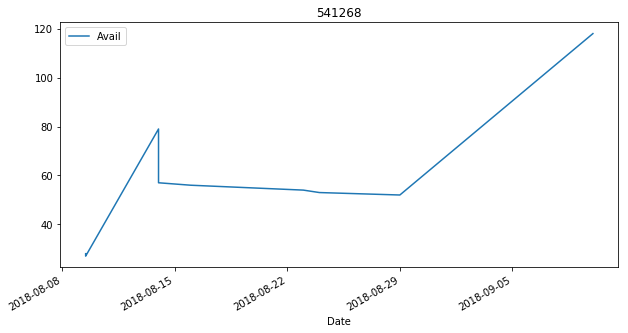

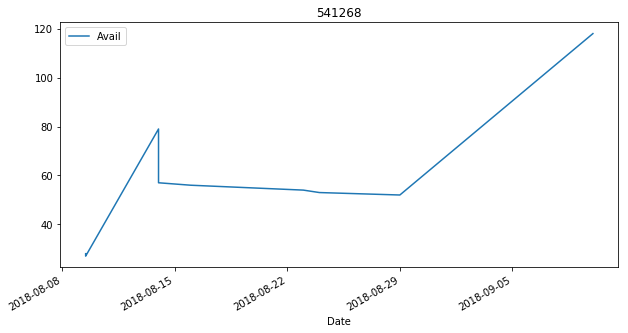

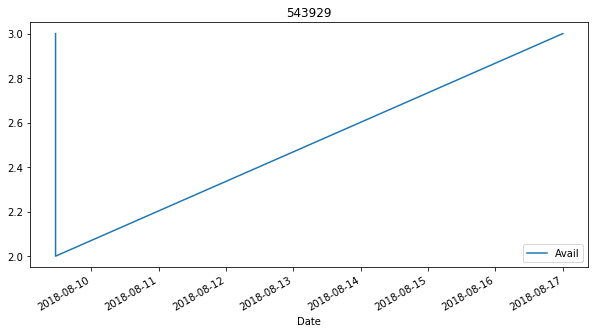

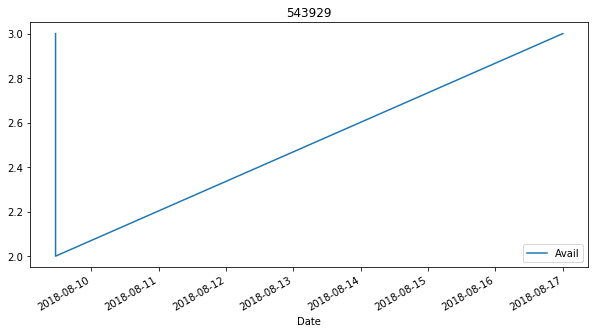

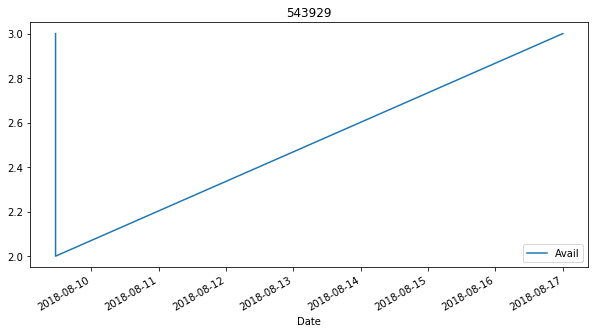

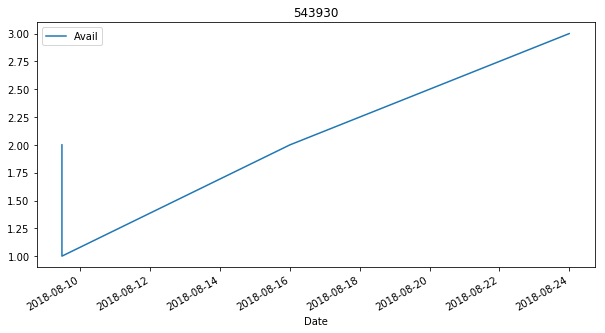

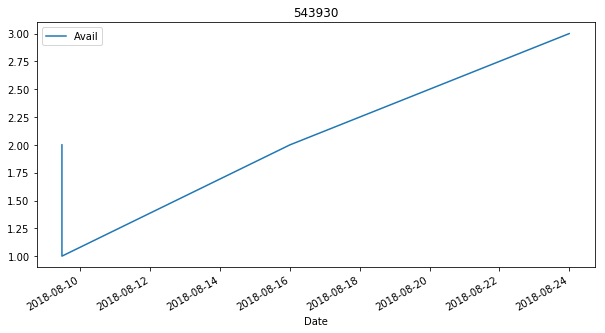

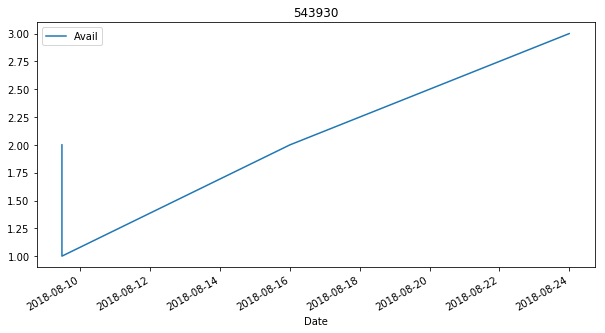

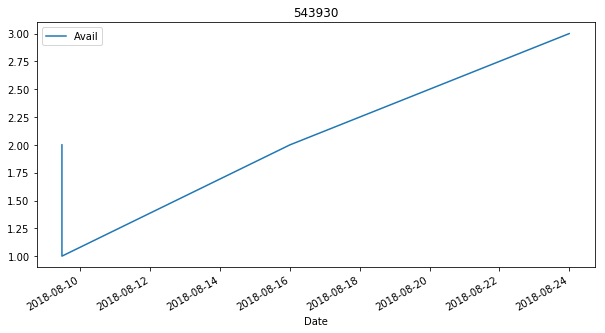

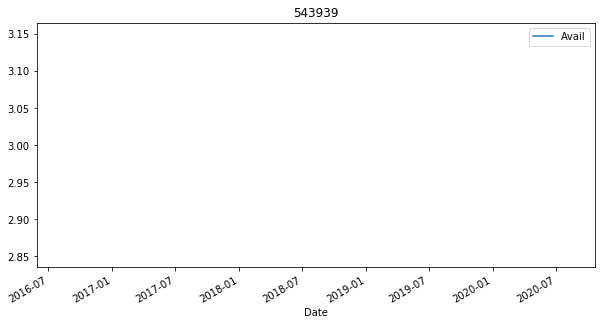

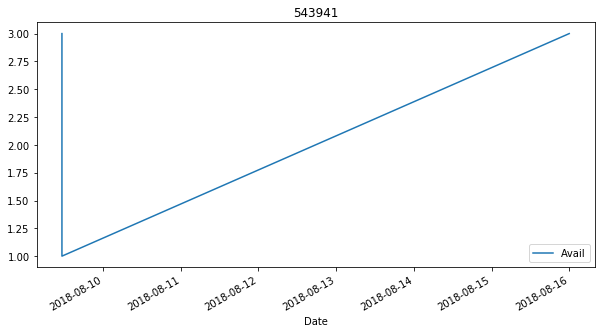

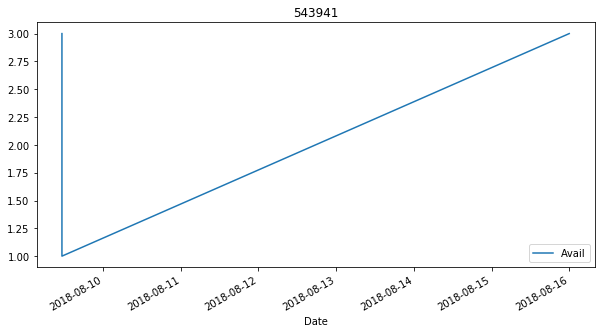

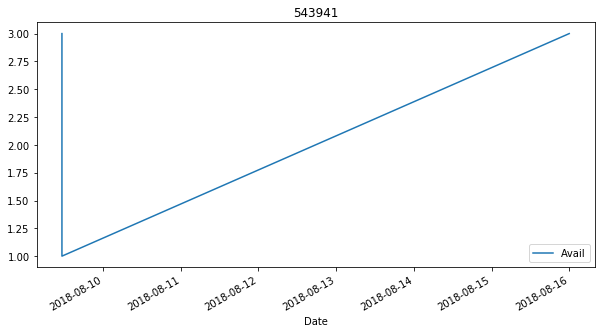

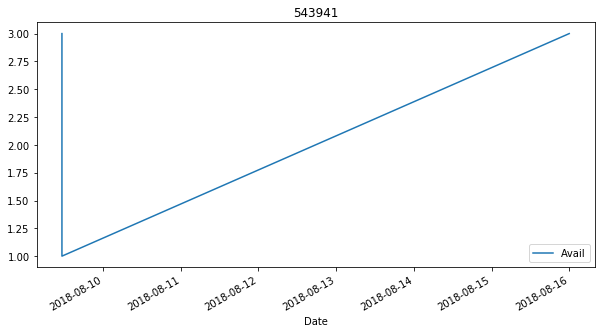

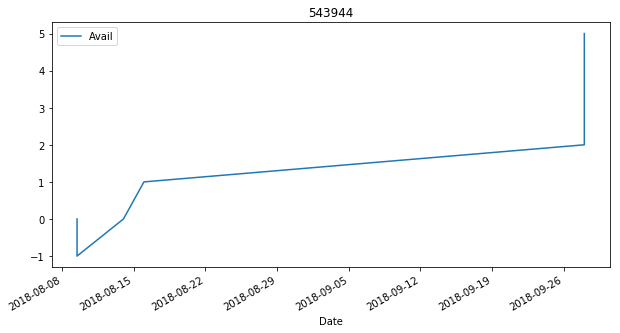

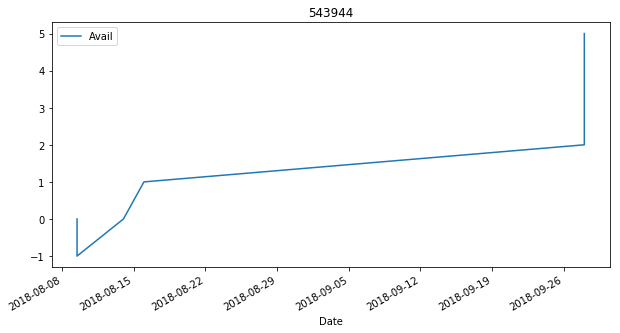

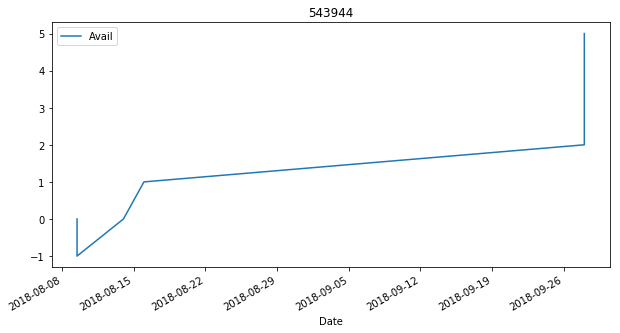

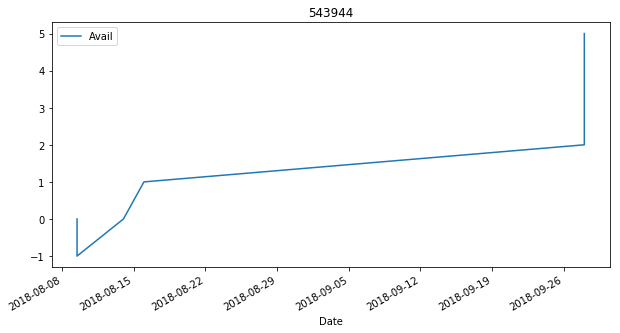

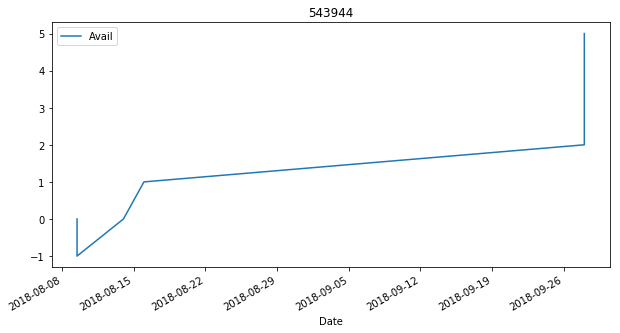

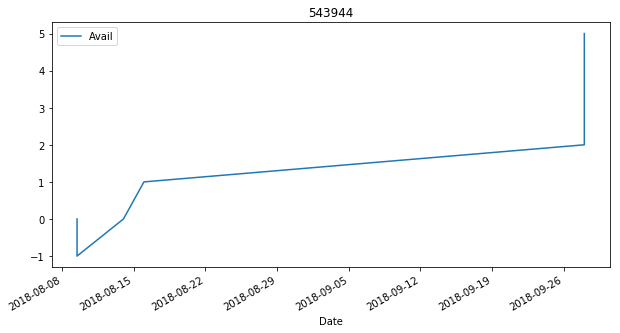

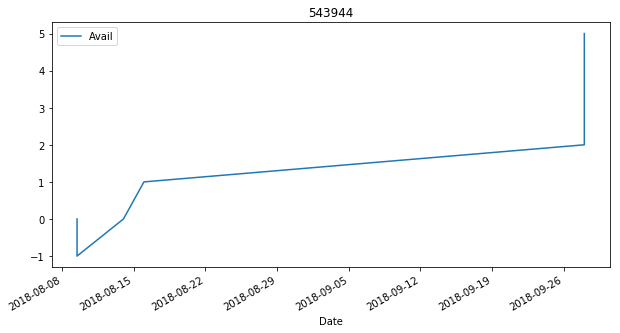

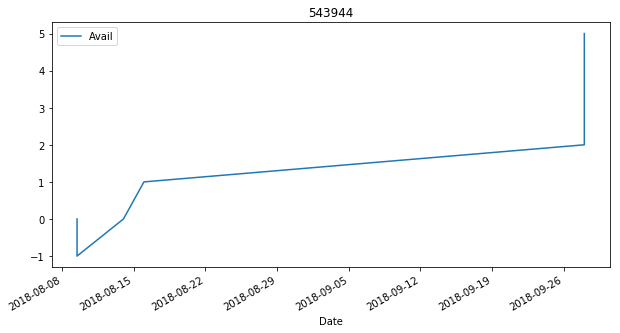

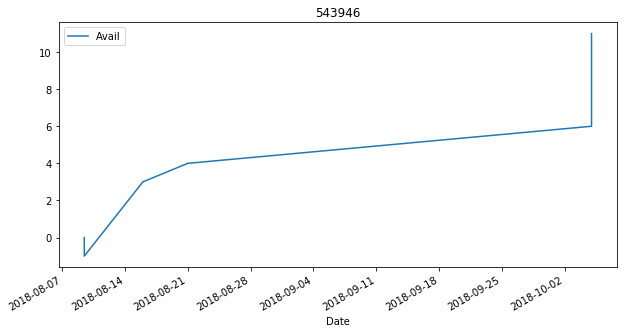

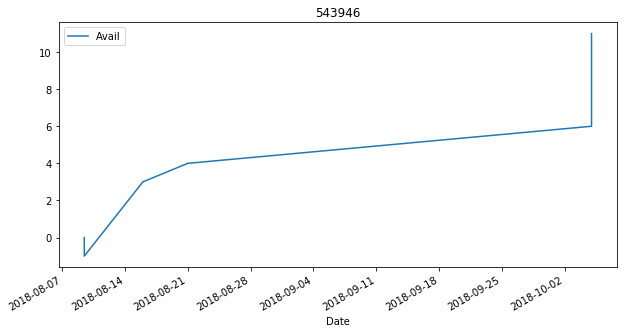

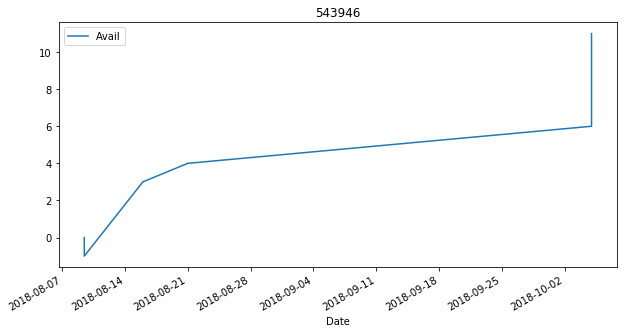

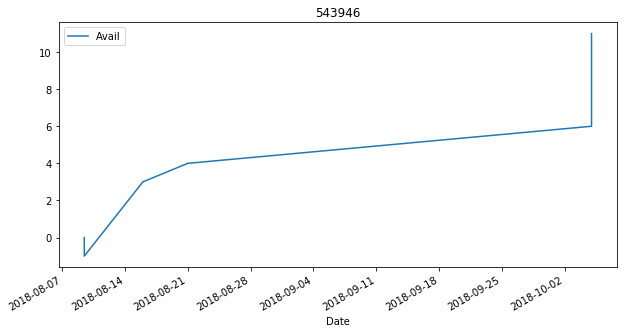

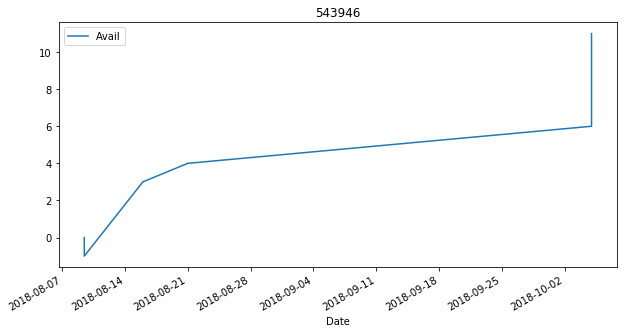

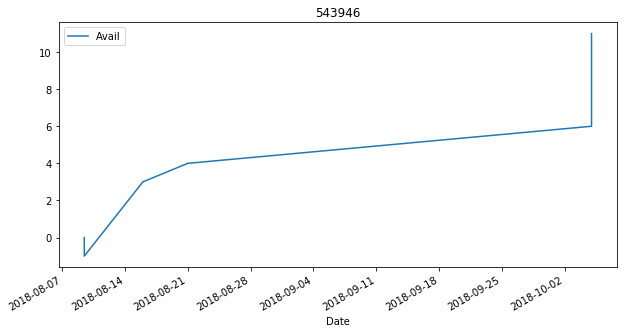

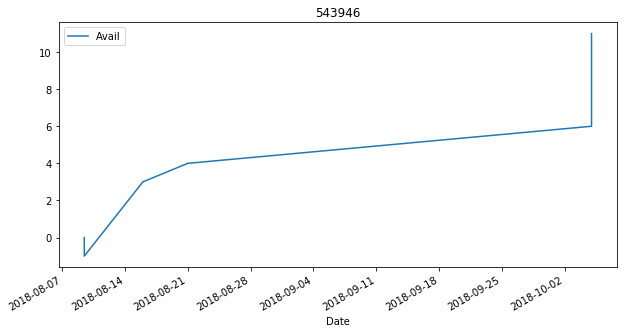

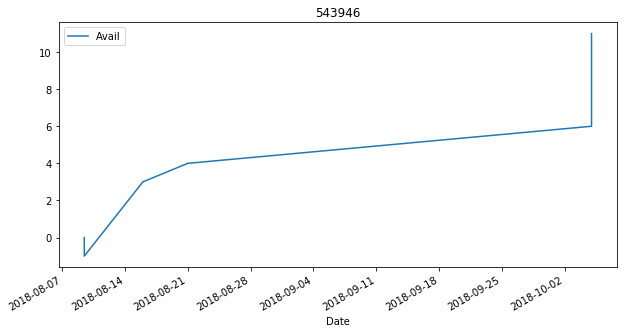

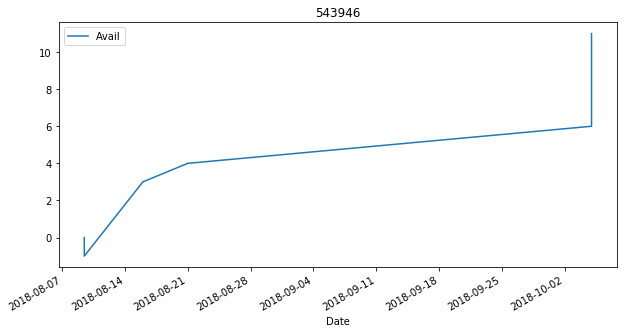

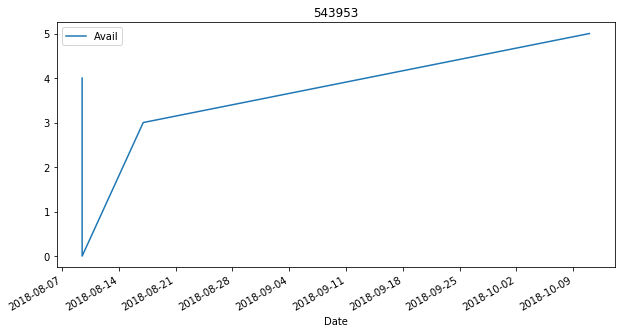

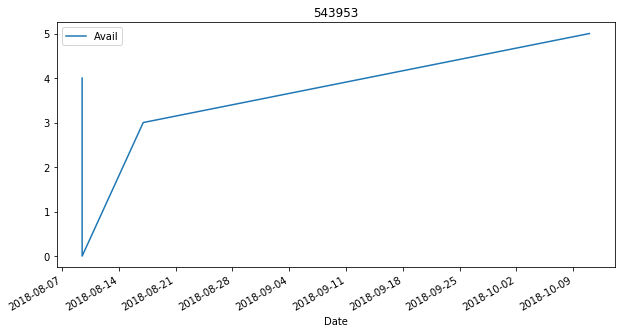

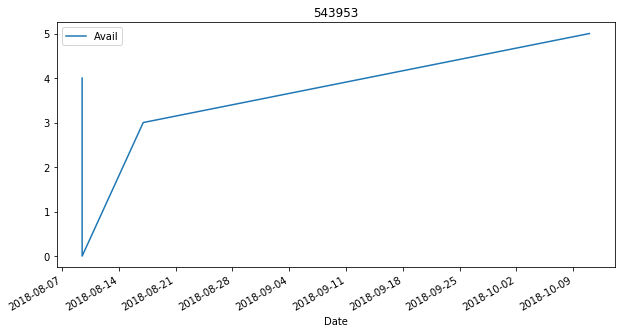

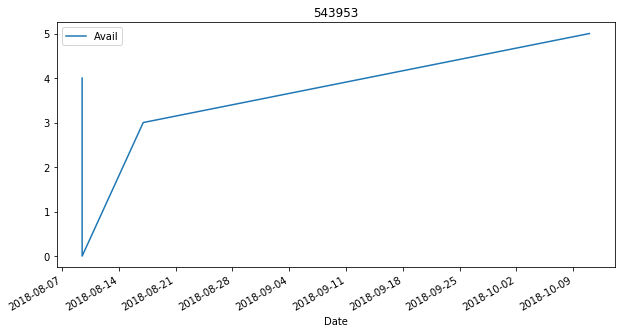

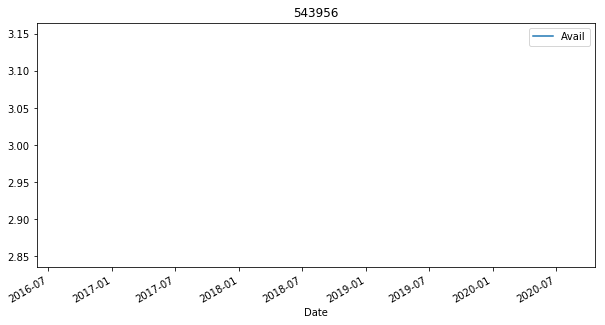

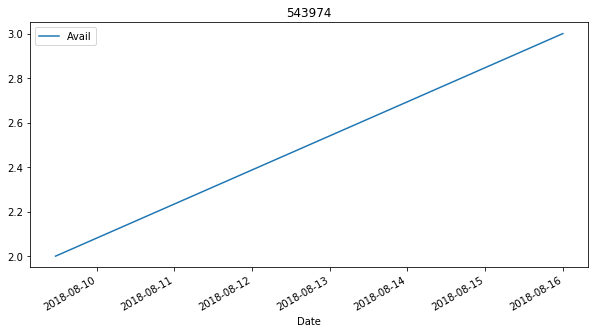

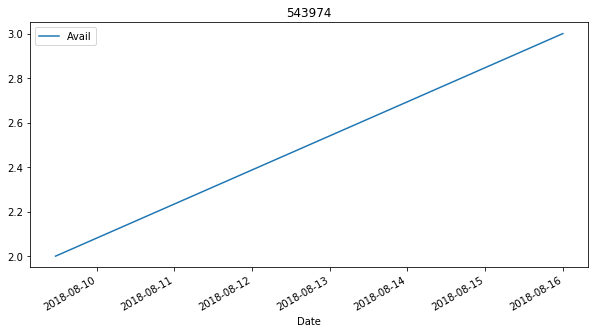

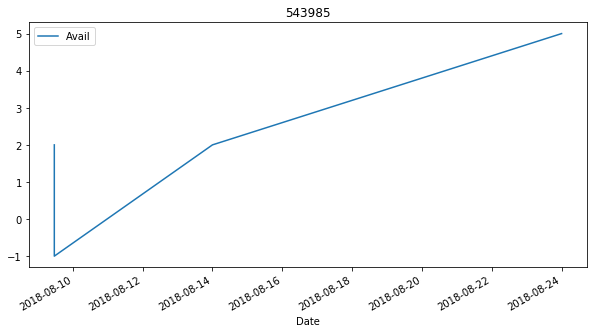

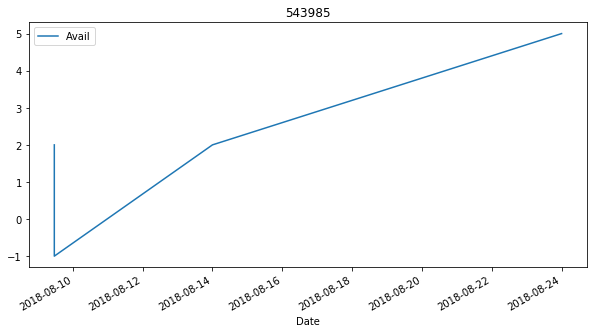

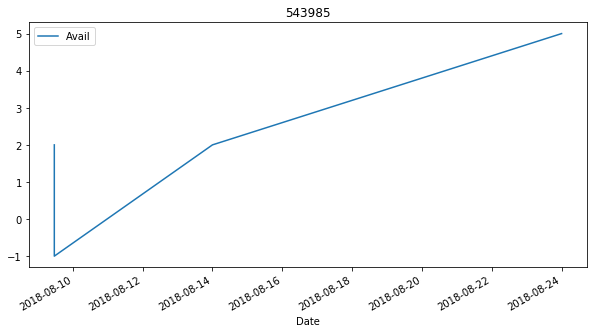

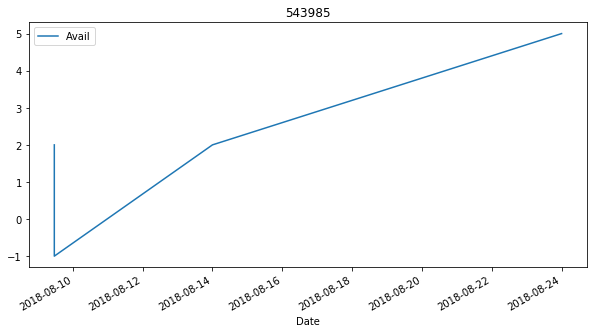

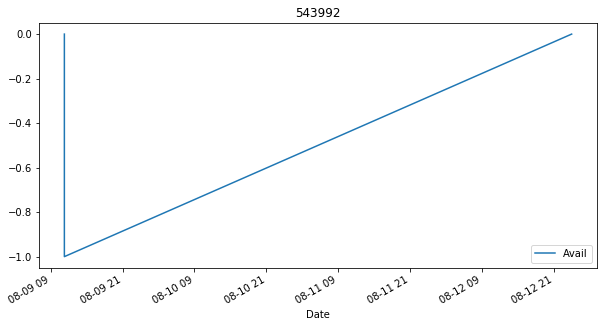

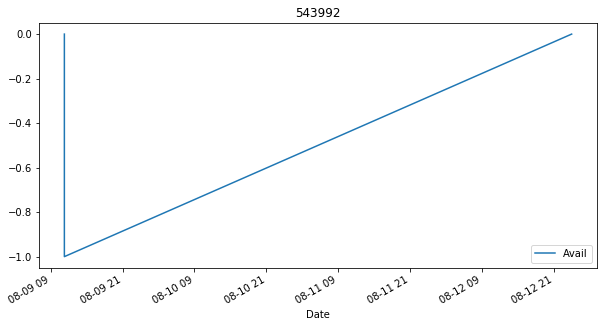

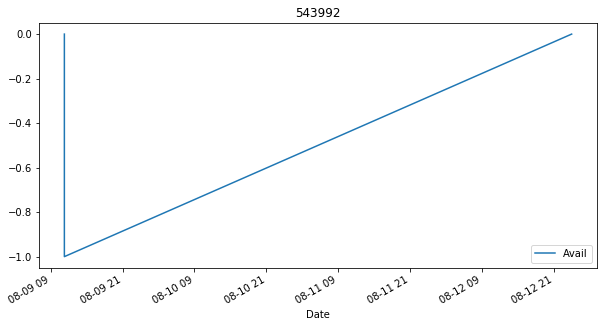

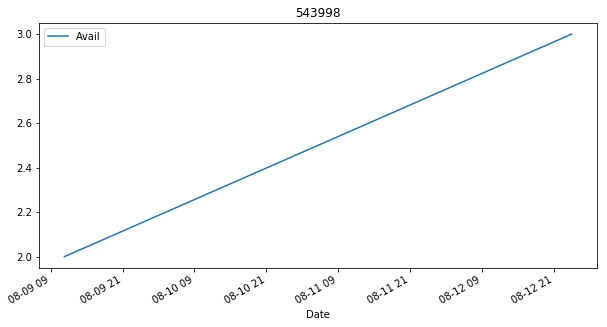

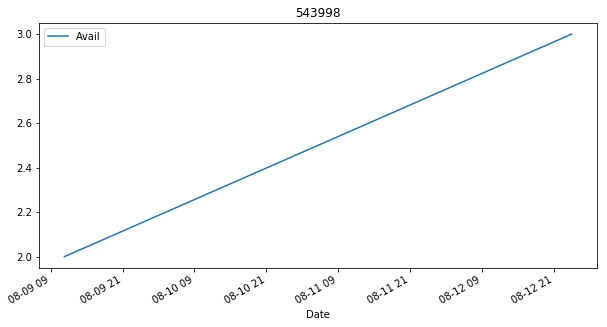

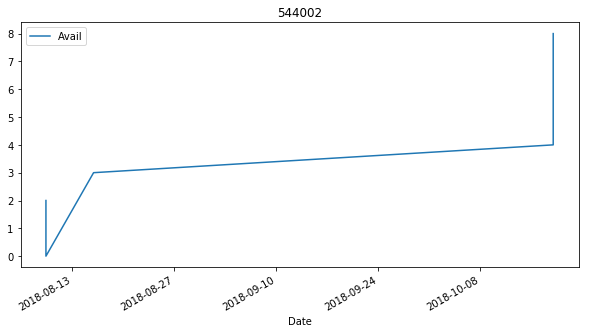

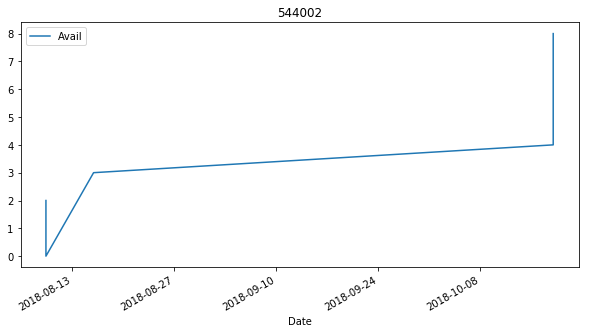

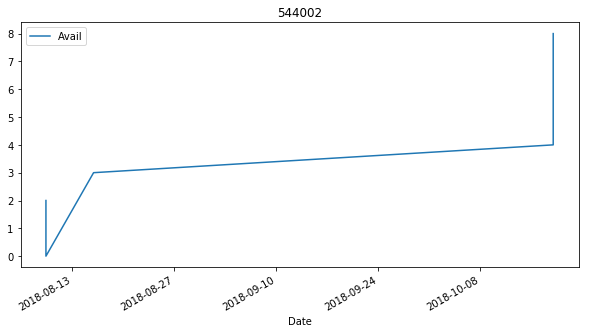

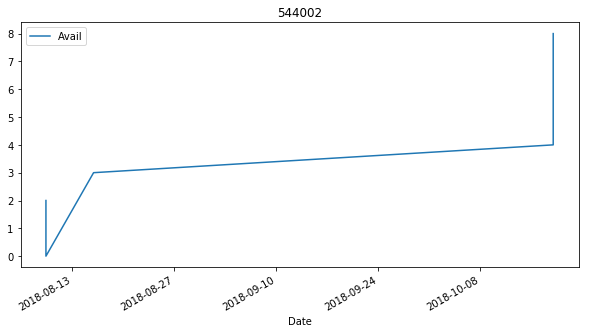

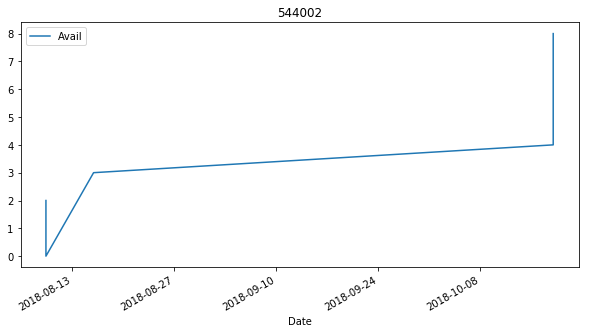

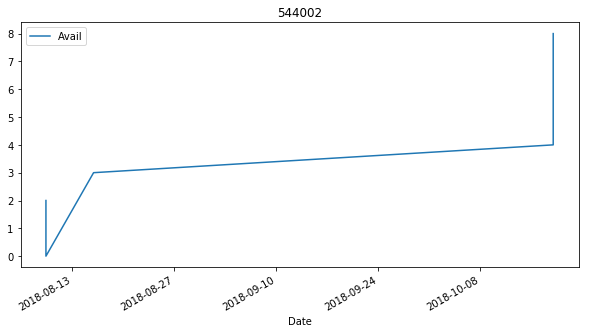

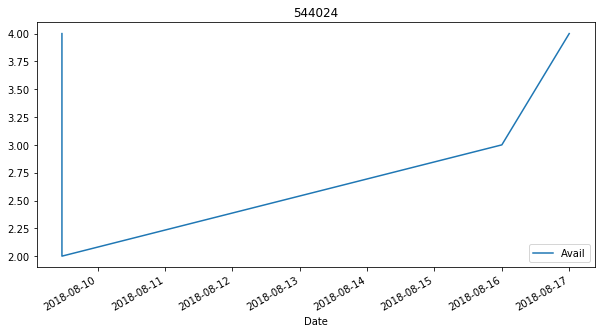

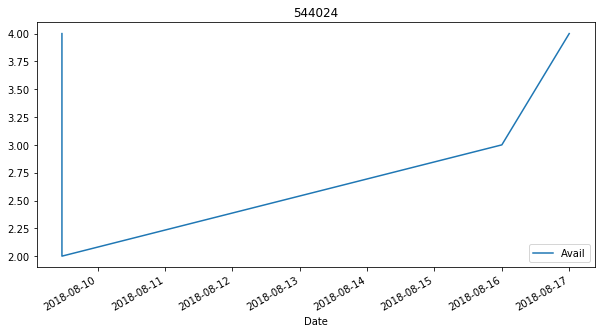

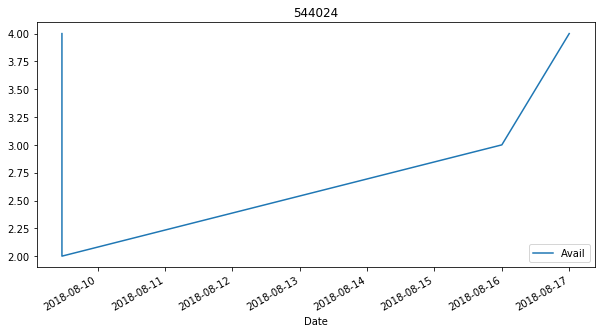

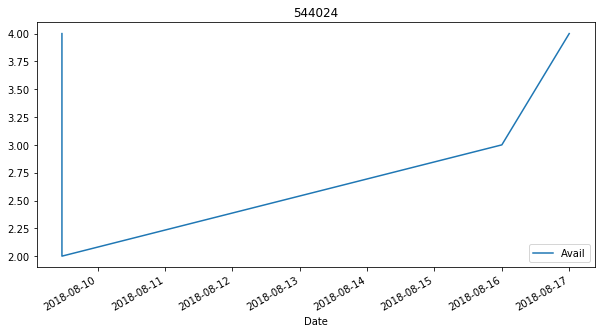

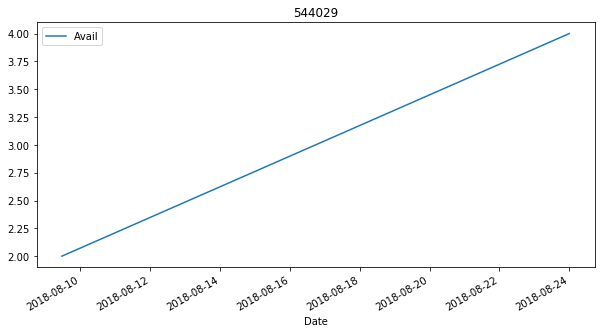

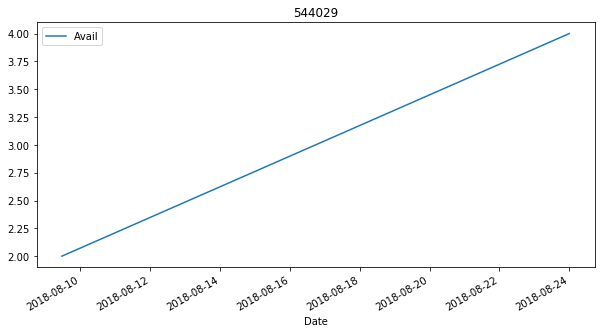

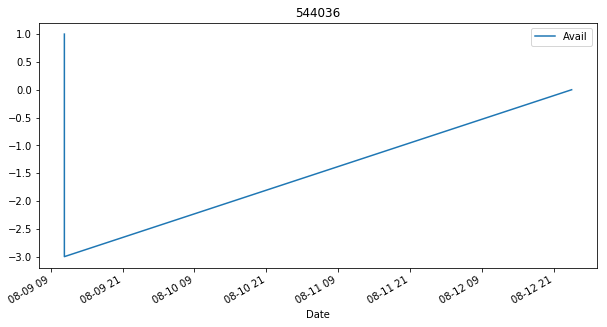

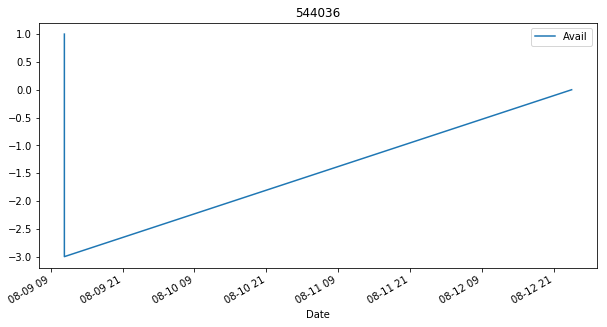

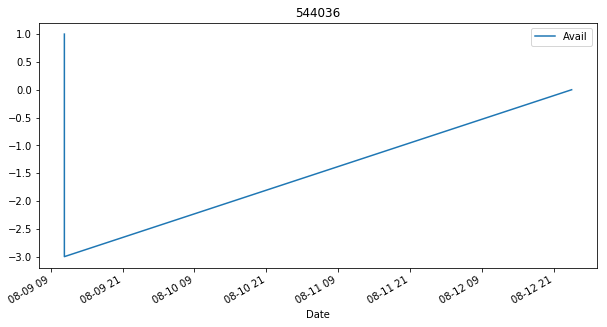

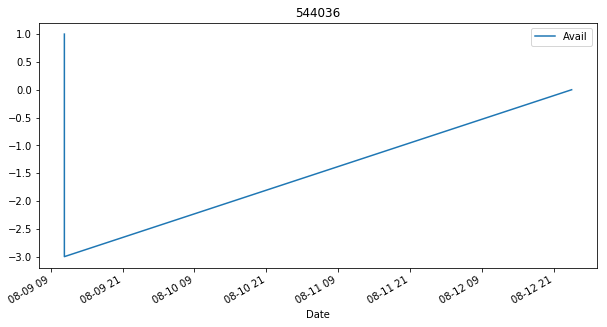

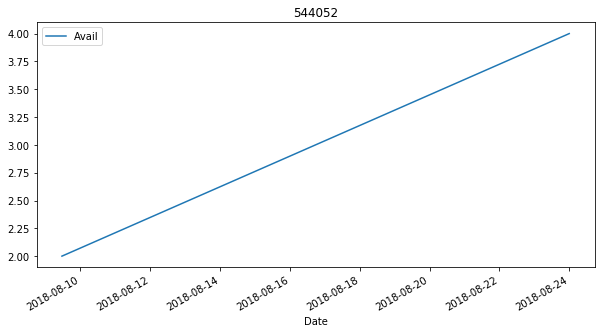

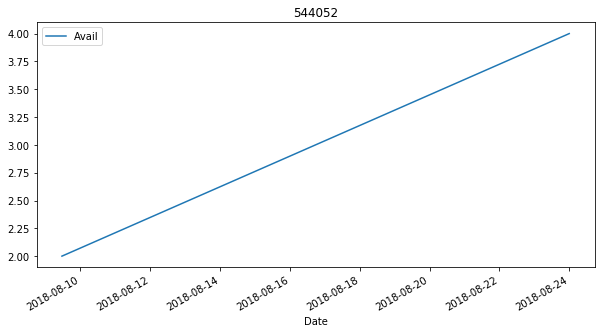

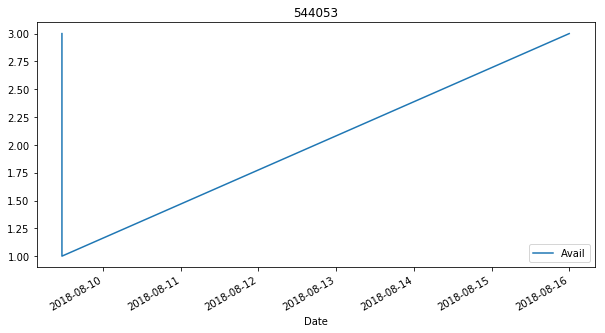

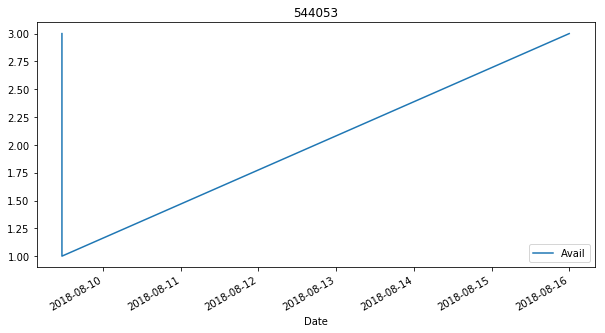

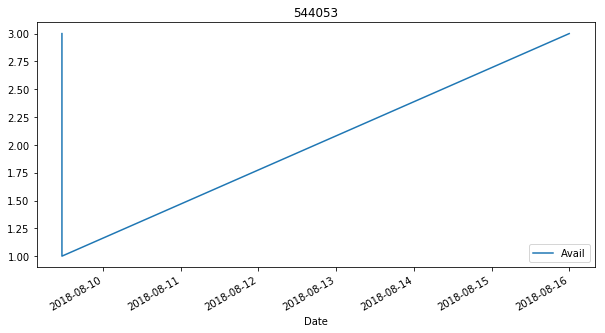

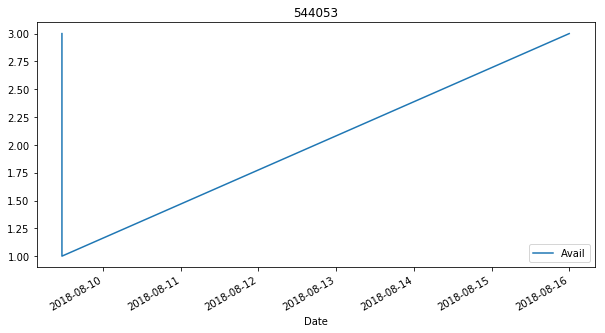

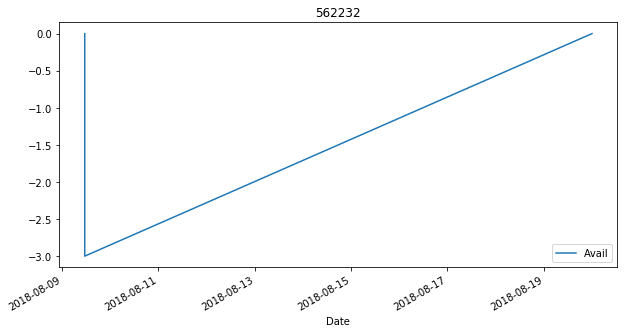

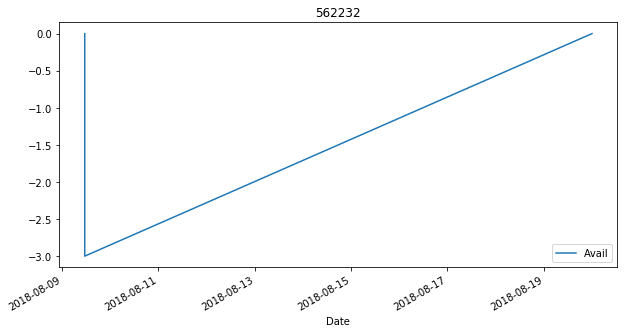

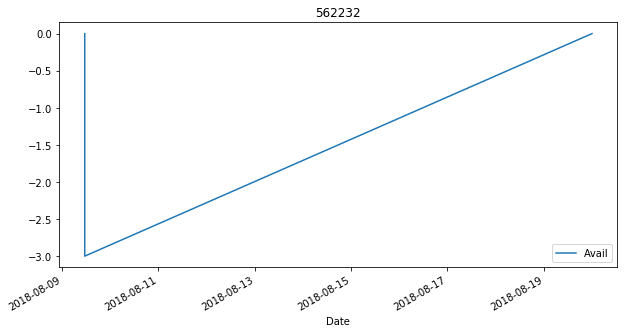

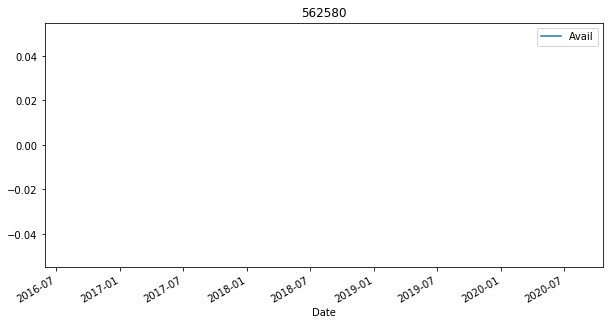

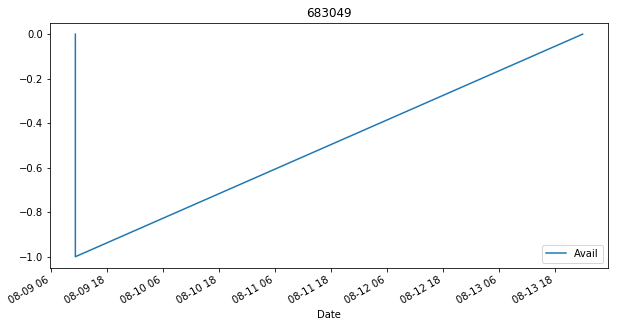

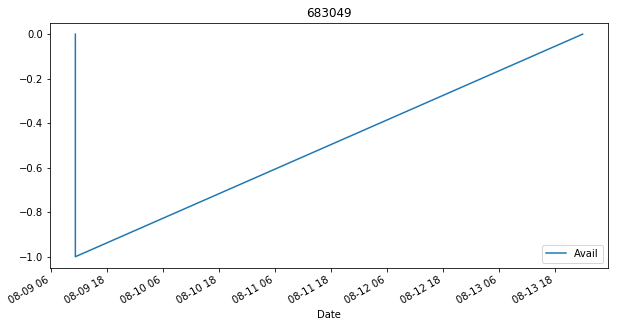

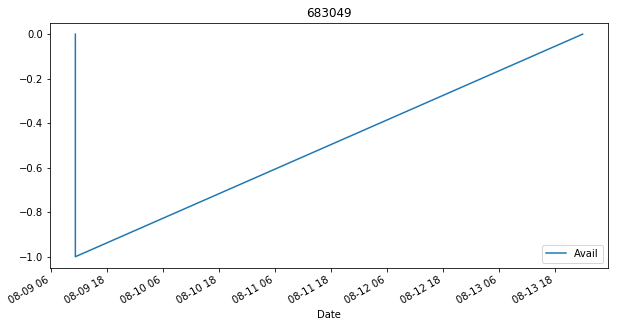

In [19]:
for partnr in queuefinal.Partnr :     
    part=mask(queuefinal,"Partnr", partnr)
    part.plot(x='Date',y='Avail', title=partnr, figsize =(10,5))